In [24]:
from ultralytics import SAM
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor


path = r"C:\Users\jules\OneDrive\Bureau\nails\index_nail_6.jpg"
img = Image.open(path)

w, h = img.size
point = (w // 2, h // 2)

# Draw the point on the image
# draw = ImageDraw.Draw(img)
# draw.ellipse(
#     (point[0] - 5, point[1] - 5, point[0] + 5, point[1] + 5), fill="red", outline="red"
# )
# img.show()

## Use fine tuned SAM2 on nails dataset


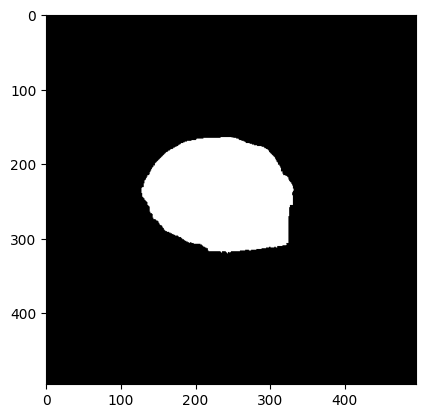

In [25]:
# Load model you need to have pretrained model already made
checkpoint = "./sam2.1_hiera_small.pt"
model_cfg = "/configs/sam2.1/sam2.1_hiera_s.yaml"
sam2_model = build_sam2(model_cfg, checkpoint, device="cuda")  # load model
predictor = SAM2ImagePredictor(sam2_model)  # load net

predictor.model.load_state_dict(torch.load("model.torch"))

image = np.array(img)

with torch.no_grad():  # prevent the net from caclulate gradient (more efficient inference)
    predictor.set_image(image)  # image encoder
    masks, scores, logits = predictor.predict(  # prompt encoder + mask decoder
        point_coords=[
            [image.shape[1] // 2, image.shape[0] // 2]
        ],  # center of the image
        point_labels=np.ones(1, dtype=int),
    )

masks = masks.astype(bool)
sorted_indices = np.argsort(scores)[::-1]  # Sort scores in descending order
sorted_masks = masks[sorted_indices].astype(bool)

seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

for i in range(sorted_masks.shape[0]):
    mask = sorted_masks[i]
    if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
        continue
    mask[occupancy_mask] = 0
    seg_map[mask] = i + 1
    occupancy_mask[mask] = 1

rgb_image = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
for id_class in range(1, seg_map.max() + 1):
    rgb_image[seg_map == id_class] = [
        255,
        255,
        255,
    ]

plt.imshow(rgb_image)
plt.show()

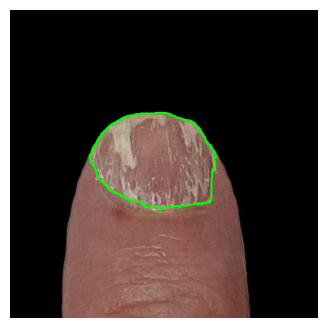

In [26]:
# Convert the RGB image to a binary mask (grayscale) for contour detection
gray_mask = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
_, binary_mask = cv2.threshold(gray_mask, 127, 255, cv2.THRESH_BINARY)

# Find contours in the thresholded mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Find the largest contour by area
largest_contour = max(contours, key=cv2.contourArea)

# Convert the original image (PIL) to OpenCV format
img_cv = np.array(img.convert("RGB"))  # Convert from PIL to NumPy array
clean_img_cv = np.copy(img_cv)  # Create a copy of the image to draw on

# Draw the largest contour on the original image in green with a thickness of 2
cv2.drawContours(img_cv, [largest_contour], -1, (0, 255, 0), thickness=2)

# Display the image with the contour
plt.figure(figsize=(4, 4))
plt.imshow(img_cv)
plt.axis("off")
plt.show()

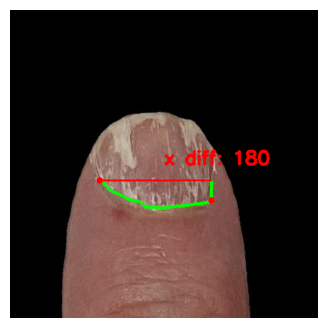

In [28]:
# copy the img_cv
img_cv = clean_img_cv.copy()

lower_point = tuple(largest_contour[largest_contour[:, :, 1].argmax()][0])
upper_point = tuple(largest_contour[largest_contour[:, :, 1].argmin()][0])

# take the y difference between the two points
y_diff = lower_point[1] - upper_point[1]

# take the point where the y is between [lower_point[1] - 0.3 * y_diff, lower_point[1]]
filtered_contour = largest_contour[
    (largest_contour[:, :, 1] >= lower_point[1] - 0.3 * y_diff)
    & (largest_contour[:, :, 1] <= lower_point[1])
]


# unsqueeze the contour to make it 3D
filtered_contour = np.expand_dims(filtered_contour, axis=1)

for pt in filtered_contour:
    cv2.circle(img_cv, (pt[0][0], pt[0][1]), 2, (0, 255, 0), -1)

biggest_x = filtered_contour[filtered_contour[:, :, 0].argmax()][0]
smallest_x = filtered_contour[filtered_contour[:, :, 0].argmin()][0]

# absolute difference between the x values
x_diff = abs(biggest_x[0] - smallest_x[0])

# add the points to the image
cv2.circle(img_cv, (biggest_x[0], biggest_x[1]), 5, (255, 0, 0), -1)
cv2.circle(img_cv, (smallest_x[0], smallest_x[1]), 5, (255, 0, 0), -1)

# add line between the points with value of x_diff
cv2.line(
    img_cv,
    (biggest_x[0], smallest_x[1]),
    (smallest_x[0], smallest_x[1]),
    (255, 0, 0),
    2,
)

cv2.putText(
    img_cv,
    f"x diff: {x_diff}",
    (w // 2, h // 2),
    cv2.FONT_HERSHEY_SIMPLEX,
    1,
    (255, 0, 0),
    3,
)

# Display the image with the contour
plt.figure(figsize=(4, 4))
plt.imshow(img_cv)
plt.axis("off")
plt.show()

## Use Pre trained large SAM2 model 


In [38]:
model = SAM("sam2_l.pt")

results = model(path, points=[w // 2, h // 2])


image 1/1 c:\Users\jules\OneDrive\Bureau\nails\index_nail_2.jpg: 1024x1024 1 0, 4414.7ms
Speed: 37.5ms preprocess, 4414.7ms inference, 11.0ms postprocess per image at shape (1, 3, 1024, 1024)


In [39]:
masks = results[0].masks

# Convert the tensor data to a numpy array
mask_array = masks.data.cpu().numpy()[0]

# show the mask
plt.imshow(mask_array, cmap="gray")
plt.show()

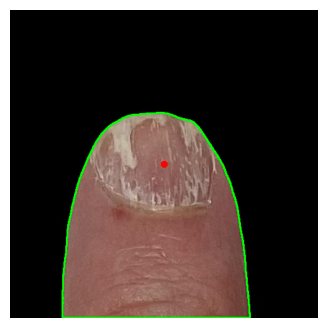

In [29]:
# Threshold the mask to make sure it's binary (0 and 255)
mask_array = (mask_array * 255).astype(np.uint8)

# Find contours in the thresholded mask
contours, _ = cv2.findContours(mask_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Find the largest contour by area
largest_contour = max(contours, key=cv2.contourArea)

# Convert the original image (PIL) to OpenCV format
img_cv = np.array(img.convert("RGB"))  # Convert from PIL to NumPy array
clean_img_cv = np.copy(img_cv)  # Create a copy of the image to draw on

# Draw the largest contour on the original image in green with a thickness of 2
cv2.drawContours(img_cv, [largest_contour], -1, (0, 255, 0), thickness=2)

# Display the image with the contour
plt.figure(figsize=(4, 4))
plt.imshow(img_cv)
plt.axis("off")
plt.show()

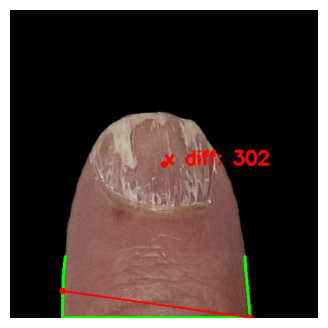

In [30]:
# copy the img_cv
img_cv = clean_img_cv.copy()

lower_point = tuple(largest_contour[largest_contour[:, :, 1].argmax()][0])
upper_point = tuple(largest_contour[largest_contour[:, :, 1].argmin()][0])

# take the y difference between the two points
y_diff = lower_point[1] - upper_point[1]

# take the point where the y is between [lower_point[1] - 0.3 * y_diff, lower_point[1]]
filtered_contour = largest_contour[
    (largest_contour[:, :, 1] >= lower_point[1] - 0.3 * y_diff)
    & (largest_contour[:, :, 1] <= lower_point[1])
]


# unsqueeze the contour to make it 3D
filtered_contour = np.expand_dims(filtered_contour, axis=1)

for pt in filtered_contour:
    cv2.circle(img_cv, (pt[0][0], pt[0][1]), 2, (0, 255, 0), -1)

biggest_x = filtered_contour[filtered_contour[:, :, 0].argmax()][0]
smallest_x = filtered_contour[filtered_contour[:, :, 0].argmin()][0]

# absolute difference between the x values
x_diff = abs(biggest_x[0] - smallest_x[0])

# add the points to the image
cv2.circle(img_cv, (biggest_x[0], biggest_x[1]), 5, (255, 0, 0), -1)
cv2.circle(img_cv, (smallest_x[0], smallest_x[1]), 5, (255, 0, 0), -1)

# add line between the points with value of x_diff
cv2.line(
    img_cv, (biggest_x[0], biggest_x[1]), (smallest_x[0], smallest_x[1]), (255, 0, 0), 2
)

cv2.putText(
    img_cv,
    f"x diff: {x_diff}",
    (w // 2, h // 2),
    cv2.FONT_HERSHEY_SIMPLEX,
    1,
    (255, 0, 0),
    3,
)

# Display the image with the contour
plt.figure(figsize=(4, 4))
plt.imshow(img_cv)
plt.axis("off")
plt.show()